# XGBoost

## Read data

In [129]:
import os

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from typing import List

df_price = pd.read_parquet("../data/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet").reset_index()
df_price_generated_00257 = pd.read_parquet("../data/scenarios synthetiques/prix/00257.parquet")

In [2]:
print(df_price.index.min())
print(df_price.index.max())
df_price.head()

0
35063


,date,price
0,2016-12-31 23:00:00+00:00,58.82
1,2017-01-01 00:00:00+00:00,58.23
2,2017-01-01 01:00:00+00:00,51.95
3,2017-01-01 02:00:00+00:00,47.27
4,2017-01-01 03:00:00+00:00,45.49


In [3]:
print(df_price_generated_00257["dayofweek"].min())
print(df_price_generated_00257["dayofweek"].max())
df_price_generated_00257.head()

0
6


,price,dayofweek,hourofday
0,31.66,0,0
1,31.06,0,1
2,27.81,0,2
3,27.54,0,3
4,25.04,0,4


## Preprocess data

In [30]:
def preprocess_true_data(df):
    # df['date'] = pd.to_datetime(df['date'])
    new_df = df.copy()
    new_df['dayofweek'] = new_df['date'].dt.dayofweek
    new_df['hourofday'] = new_df['date'].dt.hour
    new_df['dayofyear'] = new_df['date'].dt.dayofyear
    new_df["dayofseries"] = (new_df["date"] - new_df["date"].min()).dt.days
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    
    return new_df

In [31]:
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.head()

,date,price,dayofweek,hourofday,dayofyear,dayofseries,hoursofseries
0,2016-12-31 23:00:00+00:00,58.82,5,23,366,0,23
1,2017-01-01 00:00:00+00:00,58.23,6,0,1,0,0
2,2017-01-01 01:00:00+00:00,51.95,6,1,1,0,1
3,2017-01-01 02:00:00+00:00,47.27,6,2,1,0,2
4,2017-01-01 03:00:00+00:00,45.49,6,3,1,0,3


In [32]:
def preprocess_synthetic_data(df):
    new_df = df.copy()
    new_df['dayofseries'] = 0
    
    day = -1
    for i in range(0, len(new_df)):
        if i % 24 == 0:
            day += 1
        new_df.loc[i, 'dayofseries'] = day
    
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    return new_df

In [33]:
df_price_generated_00257_preprocessed = preprocess_synthetic_data(df_price_generated_00257)
df_price_generated_00257_preprocessed.head()

,price,dayofweek,hourofday,dayofseries,hoursofseries
0,31.66,0,0,0,0
1,31.06,0,1,0,1
2,27.81,0,2,0,2
3,27.54,0,3,0,3
4,25.04,0,4,0,4


## Plot data

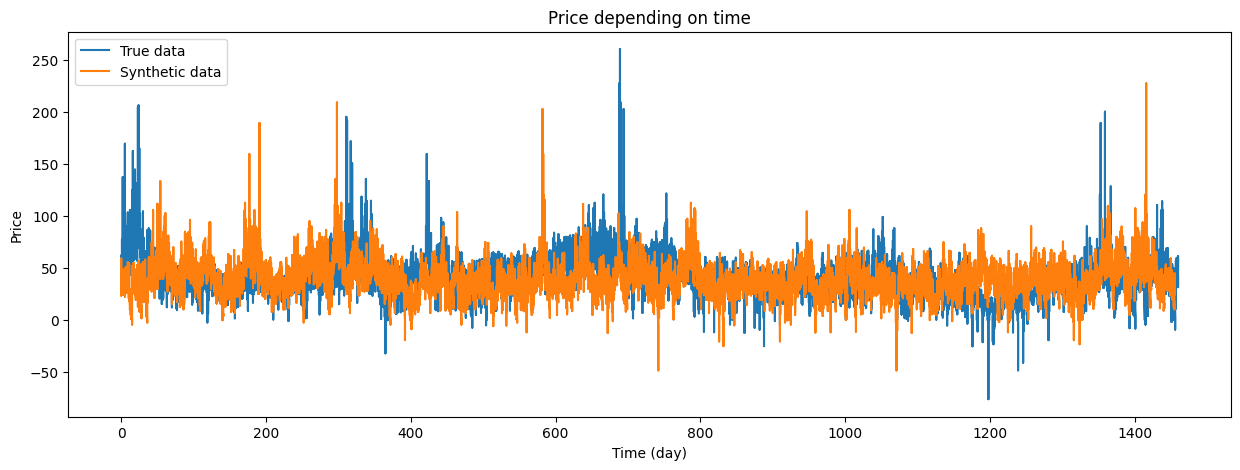

In [8]:
plt.figure(figsize=(15,5))
plt.plot(df_price_preprocessed["dayofseries"], df_price_preprocessed["price"], label="True data")
plt.plot(df_price_generated_00257_preprocessed["dayofseries"], df_price_generated_00257_preprocessed["price"], label="Synthetic data")
plt.title('Price depending on time')
plt.xlabel('Time (day)')
plt.ylabel('Price')
plt.legend()

plt.show()

## Feature Engineering

One example x is `[dayofweek, hourofday, dayofseries]` or another set of attributes and y is `price`

In [9]:
def get_x_y_point_by_point(df, x_keys: List[str], y_key: str):
    X = df[x_keys]
    y = df[y_key]
    return X, y

One example x is a sequence of values of one attribute (e.g. x is `dayofseries_1, dayofseries_2, ..., dayofseries_5`) using a window and y is `price`

In [114]:
def get_x_y_window(df, y_key: str, window_size: int, window_step: int, horizon: int):
    X , y  = [], []
    
    for i in range(0, len(df[y_key]) - window_size - horizon, window_step):
        X.append(df[y_key][i:i+window_size])
        y.append(df[y_key][i+window_size:i+window_size+horizon])
        
    return X, y

## Train & Test Splits

In [11]:
def split_data(df, horizon):
    train_df = df[:-horizon]
    test_df = df[-horizon:]
    return train_df, test_df

## Training functions

In [12]:
def get_best_params(X_train, y_train):
    xgb_model = xgb.XGBRegressor()
    reg_cv = GridSearchCV(xgb_model, {'max_depth': [1,5,10], 'n_estimators': [50, 200, 500], 'learning_rate': [0.001, 0.01, 0.1]}, verbose=1)
    reg_cv.fit(X_train, y_train)
    return reg_cv.best_params_

def train_model(X_train, y_train, params=None):
    if params is None:
        xgb_model = xgb.XGBRegressor()
    else:
        xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train,y_train)
    
    return xgb_model

def plot_predictions_vs_real(x_test, y_test, predictions):
    x_test_total_hours = x_test["dayofseries"]*24 + x_test["hourofday"]
    plt.scatter(x_test_total_hours, y_test, color = 'r', label="True")
    plt.scatter(x_test_total_hours, predictions, color = 'b', label="Prediction")
    plt.title('Real vs predicted prices depending on time')
    plt.xlabel('Time (h)')
    plt.ylabel('Price')
    plt.legend()

    plt.show()

## Point by point

### Without data augmentation

#### Search hyper params

In [13]:
train_data, test_data = split_data(df_price_preprocessed, 24)
X_train, y_train = get_x_y_point_by_point(train_data, ["dayofweek", "hourofday", "dayofseries"], "price")
X_test, y_test = get_x_y_point_by_point(test_data, ["dayofweek", "hourofday", "dayofseries"], "price")

# params = get_best_params(X_train, y_train)
params = {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}

#### Train and eval

MSE: 184.99076324861835


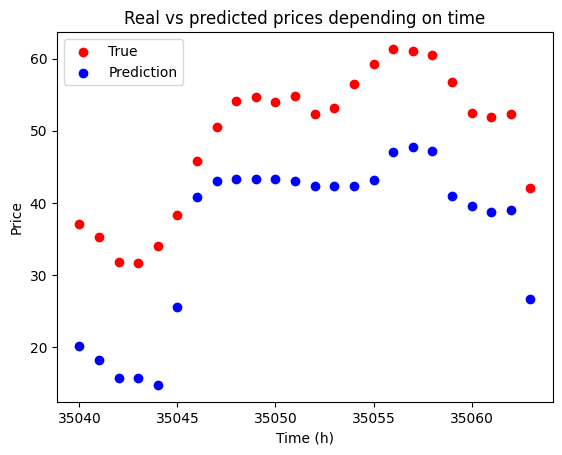

In [14]:
xgb_model = train_model(X_train, y_train, params)
predictions = xgb_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, predictions))
plot_predictions_vs_real(X_test, y_test, predictions)

### With provided data augmentation (synthetic data)

In [17]:
def load_synthetic_data_point_by_point(path):
    X_train_all, y_train_all = [], []
    for filename in tqdm(os.listdir(path)):
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            X_train, y_train = get_x_y_point_by_point(df_preprocessed, ["dayofweek", "hourofday", "dayofseries", "hoursofseries"], "price")
            
            X_train_all.append(X_train)
            y_train_all.append(y_train)
    
    X_train_all = pd.concat(X_train_all)
    y_train_all = pd.concat(y_train_all)

    return X_train_all, y_train_all

In [22]:
directory = "../data/scenarios synthetiques/prix/"
X_train_synthetic, y_train_synthetic = load_synthetic_data_point_by_point(directory)
X_train_all = pd.concat([X_train, X_train_synthetic])
y_train_all = pd.concat([y_train, y_train_synthetic])

MSE: 54.24183809150504


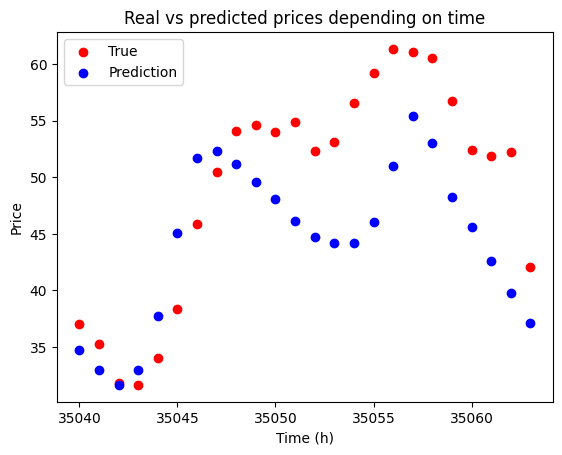

In [23]:
xgb_model = train_model(X_train_synthetic, y_train_synthetic, params)
predictions = xgb_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, predictions))
plot_predictions_vs_real(X_test, y_test, predictions)

## Window

### Without data augmentation

#### Search hyper params

In [152]:
def plot_predictions_vs_real_window(X_test, y_test, predictions):
    plt.figure(figsize=(15,5))

    y_true = np.concat([X_test[0], y_test[0]])
    x_true = np.arange(0, len(y_true))
    
    y_preds = predictions[0]
    x_preds = np.arange(len(X_test[0]), len(X_test[0])+len(y_preds))
    
    plt.scatter(x_true, y_true, color = 'r', label="True")
    plt.scatter(x_preds, predictions, color = 'b', label="Prediction")
    plt.title('Real vs predicted prices depending on time')
    plt.xlabel('Time (h)')
    plt.ylabel('Price')
    plt.legend()

    plt.show()

In [121]:
train_data, test_data = split_data(df_price_preprocessed, 24+12+12)
X_train, y_train = get_x_y_window(train_data, "price", 24, 12, 12)
X_test, y_test = get_x_y_window(test_data, "price", 24, 12, 12)
# params = get_best_params(X_train, y_train)

#### Train and eval

In [154]:
xgb_model = train_model(X_train, y_train, params)
predictions = xgb_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, predictions))

MSE: 24.766885680771406


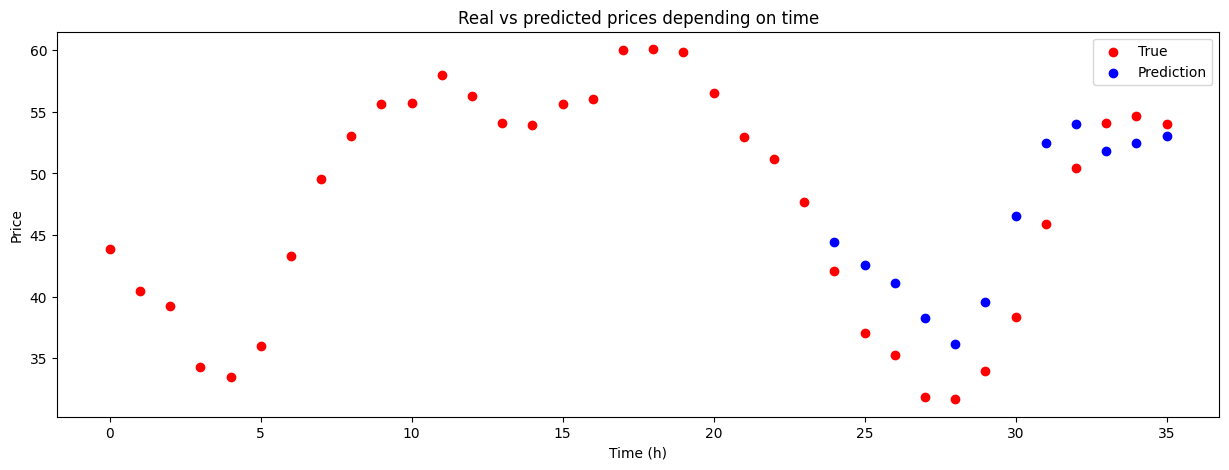

In [155]:
plot_predictions_vs_real_window(X_test, y_test, predictions)

### With provided data augmentation (synthetic data)

In [178]:
def load_synthetic_data_window(path):
    X_train_all, y_train_all = [], []
    i = 2
    for filename in tqdm(os.listdir(path)):
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            
            X_train, y_train = get_x_y_window(df_preprocessed, "price", 24, 12, 12)
            
            X_train_all.extend(X_train)
            y_train_all.extend(y_train)

    return X_train_all, y_train_all

In [179]:
directory = "../data/scenarios synthetiques/prix/"
X_train_synthetic, y_train_synthetic = load_synthetic_data_window(directory)
X_train_all = X_train + X_train_synthetic
y_train_all = y_train + y_train_synthetic

100%|██████████| 154/154 [05:07<00:00,  1.99s/it]


In [180]:
xgb_model = train_model(X_train_synthetic, y_train_synthetic, params)
predictions = xgb_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, predictions))

MSE: 49.19285038997316


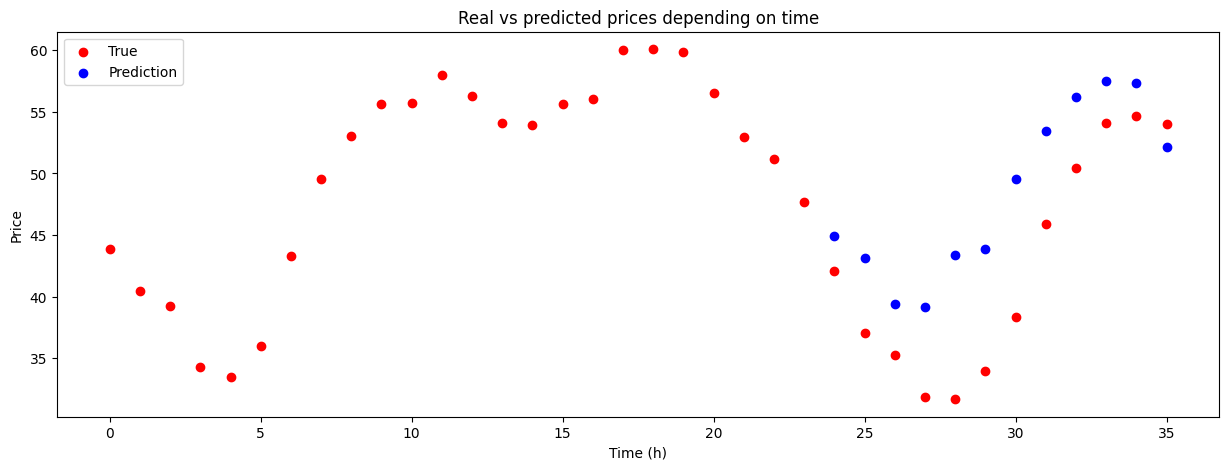

In [181]:
plot_predictions_vs_real_window(X_test, y_test, predictions)

 TODO: check https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting#Feature-Engineering